<a href="https://colab.research.google.com/github/sheashea16/AlphaCapture/blob/main/pit_sight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pit Sight


*   A neural network designed to classify the number of stones in a singular pit.
*   Each pit (1-12), can have a minimum of zero (0) stones up to a maximum of twelve (12) stones.
*   A custom dataset that I created from images of my own board and labeling each pit was used.

In [1]:
# general imports
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/mancala_dataset/train"
val_dir   = "/content/drive/MyDrive/mancala_dataset/val"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(
        brightness=0.3,
        contrast=0.3,
        saturation=0.2
    ),
    transforms.ToTensor()
])

In [4]:
# create the dataset objects
train_ds = datasets.ImageFolder(train_dir, transform=transform)
val_ds   = datasets.ImageFolder(val_dir, transform=transform)

In [5]:
# CNN Model
import torch.nn as nn

class PitSight(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.regressor = nn.Linear(64, 1)

    def forward(self, x):
      x = self.features(x)
      x = x.view(x.size(0), -1)
      return self.regressor(x).squeeze(1)

In [6]:
# model architecture
model = PitSight()
print(model)

PitSight(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (regressor): Linear(in_features=64, out_features=1, bias=True)
)


In [7]:
# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [8]:
# load previous model (optional)
#model_path = "/content/drive/MyDrive/mancala_dataset/pitsight_models/pitsight_v6.pt"
#model.load_state_dict(torch.load(model_path))

In [9]:
# define loss function and optimizer
import torch.optim as optim

criterion = nn.HuberLoss(delta=1.0)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# create DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=16)

In [51]:
# training loop

num_epochs = 100
best_val_acc = 0.79

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device)

        optimizer.zero_grad()
        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device)

            preds = torch.clamp(model(images), 0, 10)
            rounded = torch.round(preds)

            correct += (rounded == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total

    # save best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(
            model.state_dict(),
            "/content/drive/MyDrive/mancala_dataset/pitsight_models/pitsight_v6.pt"
        )
        print(f"💾 Saved new BEST model (Acc: {best_val_acc:.2%})")

    print(
        f"Epoch {epoch+1}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Acc: {val_acc:.2%}"
    )

Epoch 1/100 | Train Loss: 0.0829 | Val Acc: 62.79%
Epoch 2/100 | Train Loss: 0.0757 | Val Acc: 72.09%
Epoch 3/100 | Train Loss: 0.0847 | Val Acc: 74.42%
Epoch 4/100 | Train Loss: 0.0808 | Val Acc: 72.09%
Epoch 5/100 | Train Loss: 0.0705 | Val Acc: 67.44%
Epoch 6/100 | Train Loss: 0.0870 | Val Acc: 65.12%
Epoch 7/100 | Train Loss: 0.0935 | Val Acc: 74.42%
Epoch 8/100 | Train Loss: 0.0762 | Val Acc: 51.16%
Epoch 9/100 | Train Loss: 0.0913 | Val Acc: 69.77%
Epoch 10/100 | Train Loss: 0.1006 | Val Acc: 69.77%
Epoch 11/100 | Train Loss: 0.0772 | Val Acc: 55.81%
Epoch 12/100 | Train Loss: 0.1098 | Val Acc: 65.12%
Epoch 13/100 | Train Loss: 0.0851 | Val Acc: 74.42%
Epoch 14/100 | Train Loss: 0.0754 | Val Acc: 72.09%
Epoch 15/100 | Train Loss: 0.0783 | Val Acc: 62.79%
Epoch 16/100 | Train Loss: 0.0793 | Val Acc: 69.77%
Epoch 17/100 | Train Loss: 0.1006 | Val Acc: 76.74%
Epoch 18/100 | Train Loss: 0.0774 | Val Acc: 60.47%
Epoch 19/100 | Train Loss: 0.0781 | Val Acc: 69.77%
Epoch 20/100 | Train 

In [30]:
# save model
#torch.save(
  #model.state_dict(),
    #"/content/drive/MyDrive/mancala_dataset/pitsight_models/pitsight_v6.pt"
#)

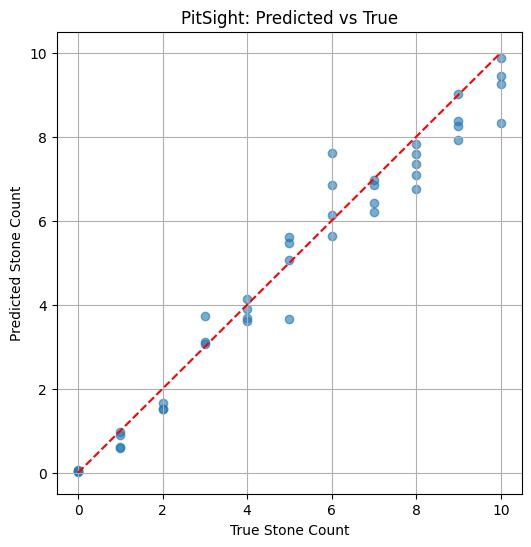

In [52]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().to(device)

        preds = model(images)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

plt.figure(figsize=(6, 6))
plt.scatter(all_labels, all_preds, alpha=0.6)
plt.plot([0, 10], [0, 10], 'r--')  # perfect prediction line

plt.xlabel("True Stone Count")
plt.ylabel("Predicted Stone Count")
plt.title("PitSight: Predicted vs True")

plt.grid(True)
plt.show()

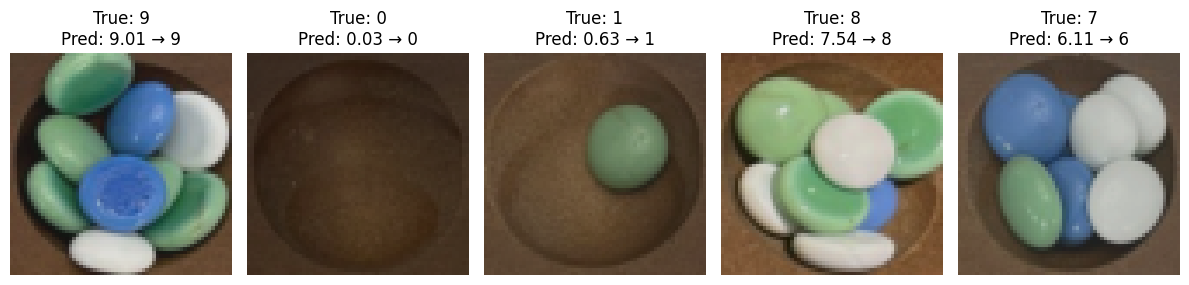

In [53]:
import random
import matplotlib.pyplot as plt
import torch
import numpy as np

model.eval()

num_examples = 5
indices = random.sample(range(len(val_ds)), num_examples)

plt.figure(figsize=(12, 4))

for i, idx in enumerate(indices):
    img, label = val_ds[idx]        # label is numeric (e.g. 4)
    label = float(label)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).item()
        pred_rounded = int(round(pred))

    plt.subplot(1, num_examples, i + 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.axis("off")
    plt.title(
        f"True: {int(label)}\nPred: {pred:.2f} → {pred_rounded}"
    )

plt.tight_layout()
plt.show()
